In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Adjusting system path to access modular scripts from src/
sys.path.append(str(Path.cwd().parent))

from src.analysis import SurveyAnalyzer
from src.loader import load_raw_data
from src.preprocessing import run_full_preprocessing

# Setting global visualization parameters for publication-quality plots
# plt.style.use("seaborn-v0_8-whitegrid")
# sns.set_context("notebook", font_scale=1.2)
%matplotlib inline

print("Environment initialized.")


Environment initialized.


### 1. Data Ingestion
At this stage, we aggregate multiple NHANES modules (Demographics, Examination, Laboratory, and Questionnaire) 
linked by the unique respondent identifier `SEQN`. 

The preprocessing pipeline includes:
* Feature selection based on clinical relevance.
* Handling of missing values using **KNN Imputation** for physiological markers.
* Deriving the **PHQ-9 Total Score** to define our target variable.

In [20]:
# Load original XPT files
raw_data = load_raw_data()

# Execute unified cleaning and imputation pipeline
df = run_full_preprocessing(raw_data)

print(
    f"Dataset successfully prepared. Total samples: {df.shape[0]}, Features: {df.shape[1]}"
)

--- DATA INGESTION ---
Merging: DPQ_J...
Merging: HSQ_J...
Merging: SMQ_J...
Merging: ALQ_J...
Merging: PAQ_J...
Merging: BMX_J...
Merging: BPX_J...
Merging: BIOPRO_J...
Merging: CBC_J...
Merging: HSCRP_J...
Merging: PBCD_J...
Merging: ALB_CR_J...
Merging: VID_J...
Merging: DXX_J...
Data Loaded. Shape: (9254, 44)
Population Filter: Dropped 3398 rows (Minors < 18). Retained: 5856
-> Imputation Complete. Final Shape: (5856, 47)
Dataset successfully prepared. Total samples: 5856, Features: 47


### 2. Quality Assurance
Before proceeding to analysis, we verify the integrity of the processed dataset, 
ensuring no critical data loss occurred during merging and imputation.

In [21]:
# Overview of the feature space and data types
display(df.info())

# Checking for any remaining null values post-imputation
null_count = df.isnull().sum().sum()
print(f"Total missing values: {null_count}")

# Preview of the structure
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      5856 non-null   float64
 1   Gender                    5856 non-null   int64  
 2   Age                       5856 non-null   float64
 3   Poverty_Ratio             5856 non-null   float64
 4   Education_Level           5856 non-null   int64  
 5   Marital_Status            5856 non-null   int64  
 6   MEC_Weight                5856 non-null   int64  
 7   PSU                       5856 non-null   int64  
 8   Strata                    5856 non-null   int64  
 9   Race                      5856 non-null   int64  
 10  DPQ060                    5856 non-null   int64  
 11  DPQ080                    5856 non-null   int64  
 12  DPQ020                    5856 non-null   int64  
 13  DPQ040                    5856 non-null   int64  
 14  DPQ090  

None

Total missing values: 0


,SEQN,Gender,Age,Poverty_Ratio,Education_Level,Marital_Status,MEC_Weight,PSU,Strata,Race,...,Lead_ugdL,Cadmium_ugL,Albumin_Creatinine_Ratio,VitaminD_nmolL,Body_Fat_Pct,Trunk_Fat_g,Lean_Mass_g,PHQ9_Score,Depression,Poverty_Missing
0,93705.0,1,66.0,0.820,2,3,8338,2,145,4,...,2.98,0.24,13.33,89.9,41,14370,44614,0,0,0
1,93706.0,0,18.0,1.932,4,2,8723,2,134,6,...,0.74,0.21,57.39,53.8,23,6359,48766,0,0,1
2,93708.0,1,66.0,1.630,1,1,14372,2,138,6,...,1.53,0.73,19.36,116.0,37,8813,31915,0,0,0
3,93709.0,1,75.0,0.410,4,2,12278,1,136,4,...,1.31,1.08,12.28,72.8,42,20331,55504,5,0,0
4,93711.0,0,56.0,5.000,5,1,12391,2,134,6,...,2.15,0.38,3.78,165.0,23,6826,45726,2,0,0


### 3. Target Variable Analysis: Depression (PHQ-9)
The Patient Health Questionnaire-9 (PHQ-9) is a multipurpose instrument for screening depression. 
A total score of **10 or greater** is a clinically recognized cutoff for moderate to severe depression.

**Key question:** What is the actual prevalence of depression in the US population after adjusting for survey weights?

In [22]:
# Calculate unweighted vs weighted prevalence to demonstrate the impact of survey design
unweighted_prev = (df["PHQ9_Score"] >= 10).mean() * 100
# Fixed call in your notebook
weighted_prev = SurveyAnalyzer.get_weighted_prevalence(
    df, target_col="PHQ9_Score", threshold=10, weight_col="MEC_Weight"
)

print(f"Unweighted Depression Prevalence: {unweighted_prev:.2f}%")
print(f"Weighted (Population-Adjusted) Prevalence: {weighted_prev:.2f}%")

Unweighted Depression Prevalence: 8.04%
Weighted (Population-Adjusted) Prevalence: 8.16%


### 4. Distribution of Depression Severity
To understand the burden of depression, we visualize the PHQ-9 scores. 
By overlaying the **weighted** distribution, we can see if the survey design 
oversamples or undersamples certain levels of mental health distress.

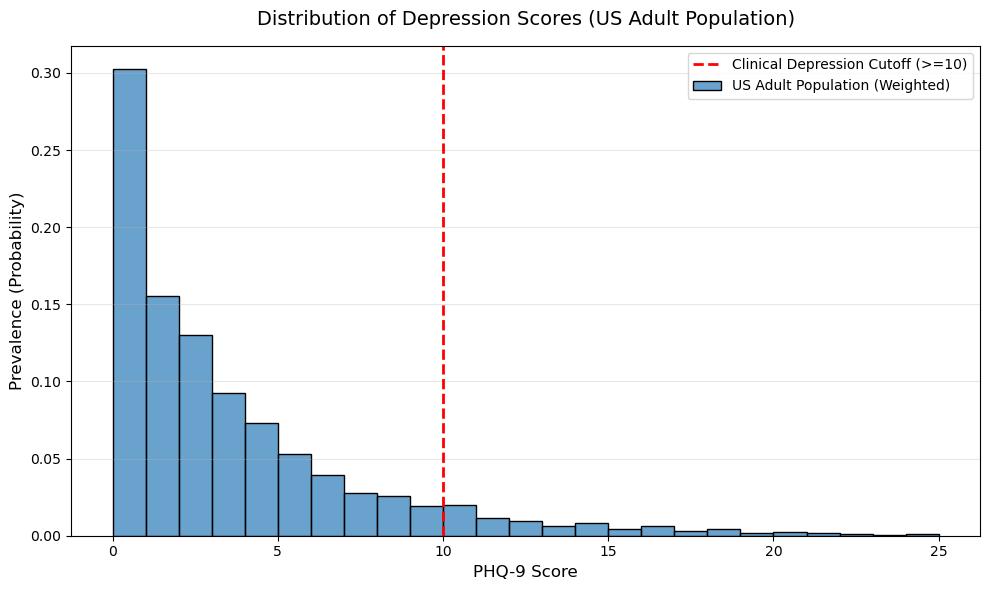

In [23]:
from src.visualizations import plot_phq9_distribution

# Visualize the distribution comparison
plot_phq9_distribution(df, weight_col="MEC_Weight")

### 5. Multivariate Analysis & Data Structure
Before examining specific risk factors, we perform a high-level scan of the dataset to understand relationships between features.

**Why not standard `df.corr()`?**
Standard correlation matrices assume each observation contributes equally. In NHANES, one row might represent 500 people while another represents 50,000. We calculate the **Weighted Pearson Correlation** to get the true population-level relationships.

**Objectives:**
1. **Multicollinearity Check:** Are biomarkers like Lead and Cadmium highly correlated? (If so, they confound each other).
2. **Target Alignment:** Which features show the strongest raw correlation with `Depression`?
3. **Outlier Detection:** Are there biological values that are biologically implausible?

Selected 14 features for Correlation Matrix.


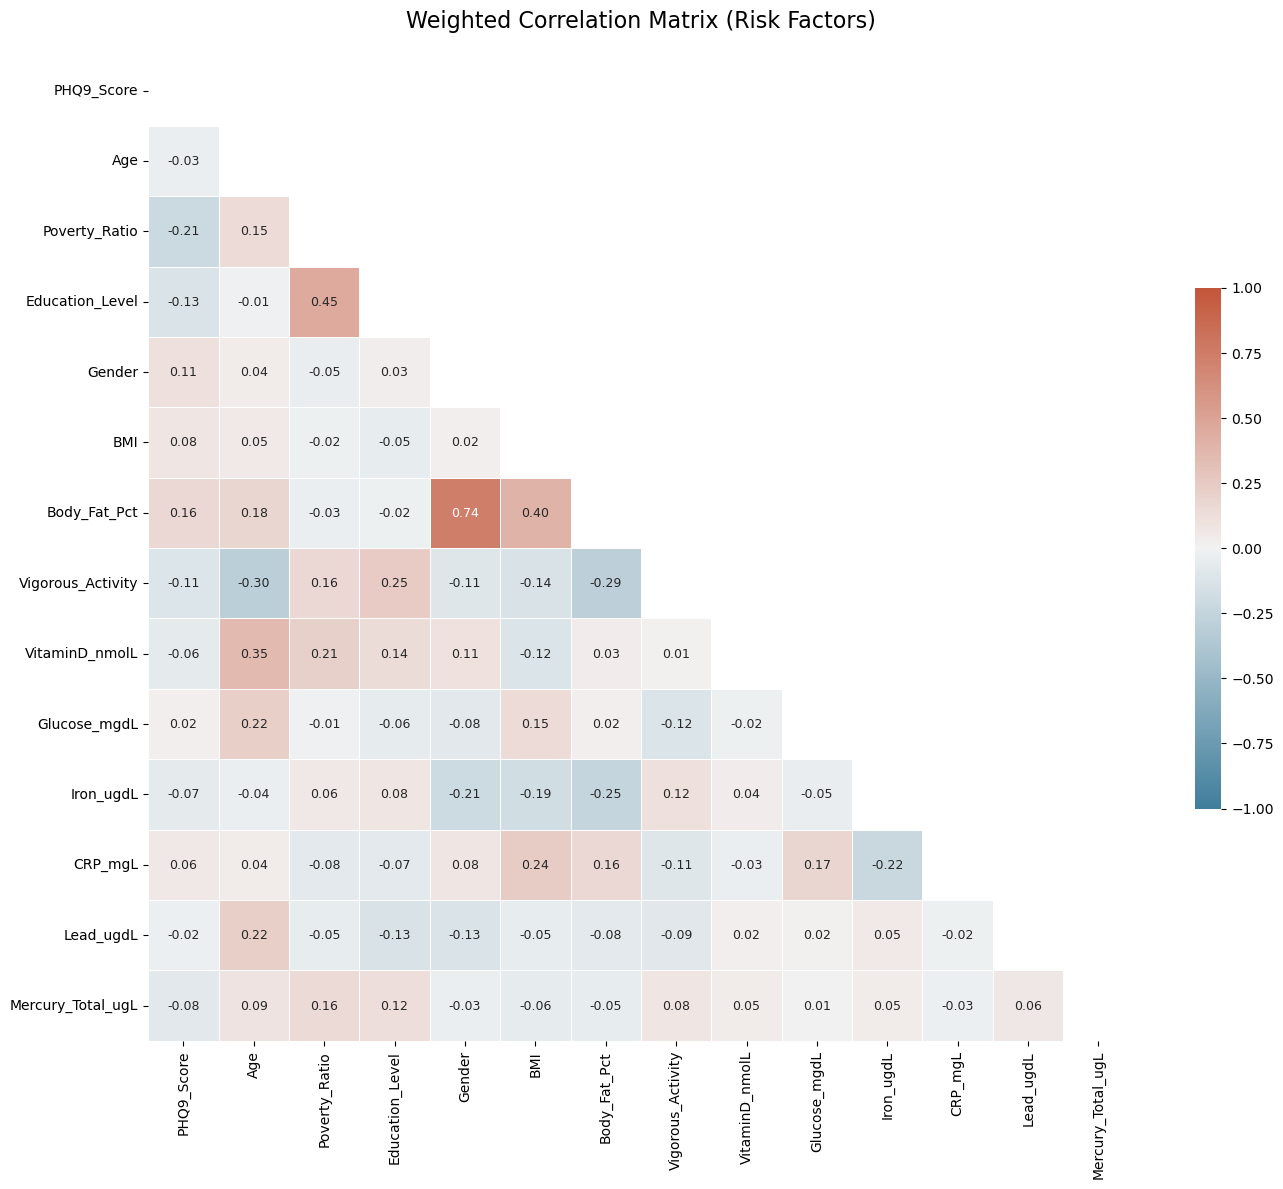

In [24]:
from src.analysis import SurveyAnalyzer
from src.visualizations import plot_correlation_heatmap

# --- Advanced Multivariate Analysis ---

# 1. Define Extended Feature Set based on Config
# We group them to see clusters of relationships
features_to_analyze = [
    # --- TARGET ---
    "PHQ9_Score",  # Continuous severity
    # --- DEMOGRAPHICS & SOCIO ---
    "Age",
    "Poverty_Ratio",  # Income
    "Education_Level",  # Higher values = Higher education
    "Gender",  # 0=Male, 1=Female (Check your encoding!)
    # --- BODY COMPOSITION (The "Muscle Armor" Hypothesis) ---
    "BMI",
    "Waist_cm",  # Central Obesity
    "Body_Fat_Pct",  # True fat percentage (better than BMI)
    # --- LIFESTYLE ---
    "Vigorous_Activity",  # Physical activity (0/1)
    # --- BIOMARKERS (Metabolism & Nutrition) ---
    "VitaminD_nmolL",  # "Sunshine Vitamin"
    "Glucose_mgdL",  # Blood sugar
    "Iron_ugdL",  # Anemia check
    # --- RISK MARKERS ---
    "CRP_mgL",  # Inflammation
    "Lead_ugdL",  # Neurotoxin
    "Mercury_Total_ugL",  # Fish consumption proxy
]

# 2. Safety Check: Only use columns that actually exist in DF
# (Important because DEXA data isn't in all NHANES cycles)
valid_features = [c for c in features_to_analyze if c in df.columns]

print(f"Selected {len(valid_features)} features for Correlation Matrix.")

# 3. Compute Weighted Correlation
# We use our custom SurveyAnalyzer because standard .corr() is biased
corr_mat = SurveyAnalyzer.get_weighted_correlation_matrix(
    df, cols=valid_features, weight_col="MEC_Weight"
)

# 4. Visualize with Cluster Map or Heatmap
# Let's stick to the clean Heatmap we built
plot_correlation_heatmap(corr_mat)

### 6. Deep Dive: The Socioeconomic Gradient
Our correlation matrix revealed a strong negative relationship between `Poverty_Ratio` and `PHQ9_Score` (-0.21). 
However, correlation implies linearity. In this section, we investigate the **shape** of this relationship.

**Hypothesis:** Is there a "threshold" of income where the risk of depression stabilizes, or is the protective effect continuous?

**Methodology:**
* We classify the `Poverty_Ratio` into clinically relevant socioeconomic groups using Federal Poverty Guidelines.
* **Groups:**
    * **Below Poverty (<1.0:** Living below the poverty line.
    * **Low Income (1.0 - 2.0):** Economically vulnerable.
    * **Middle Class (2.0 - 4.0):** Secure.
    * **High Income (>4.0):** Affluent.
* We apply weighted aggregation to estimate depression prevalence per group.

Visualizing the Socioeconomic Gradient...


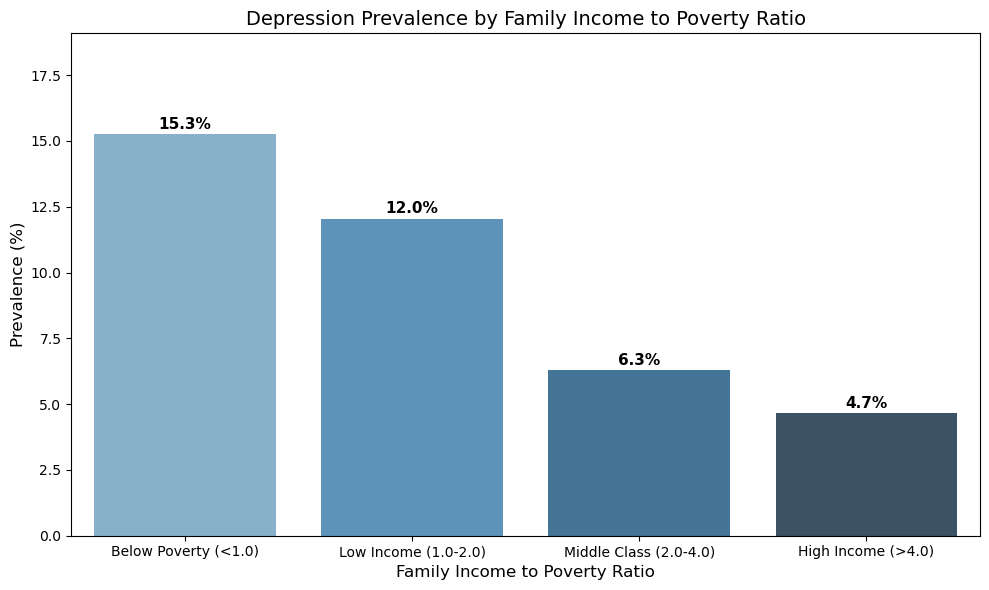

In [25]:
from src.visualizations import plot_weighted_risk_factor

# 1. Feature Engineering: Discretize Continuous Income
# Rationale: Categorical bins make the "social gradient" easier to visualize and interpret for stakeholders.
df["Income_Group"] = pd.cut(
    df["Poverty_Ratio"],
    bins=[-0.1, 1.0, 2.0, 4.0, 10.0],  # 10.0 is the cap in NHANES data
    labels=[
        "Below Poverty (<1.0)",
        "Low Income (1.0-2.0)",
        "Middle Class (2.0-4.0)",
        "High Income (>4.0)",
    ],
)

print("Visualizing the Socioeconomic Gradient...")
plot_weighted_risk_factor(
    df,
    x_col="Income_Group",
    target_col="Depression",
    xlabel="Family Income to Poverty Ratio",
)

### 7. The "Muscle Armor" Hypothesis: Interaction of Gender & Body Fat
The correlation matrix showed a high correlation between `Gender` and `Body_Fat_Pct` (0.74), which creates a **confounding effect**. Women naturally have higher essential body fat than men. Analyzing them together would skew the results.

**Methodology: Stratification**
To isolate the effect of body composition on mental health, we must stratify the analysis by Gender.
1. We calculate **Quartiles** of Body Fat Percentage to define relative groups (Low, Normal, High, Obese).
2. We compare average PHQ-9 scores across these quartiles *separately* for Men and Women.

**Goal:** Determine if body fat is an independent risk factor after controlling for gender.

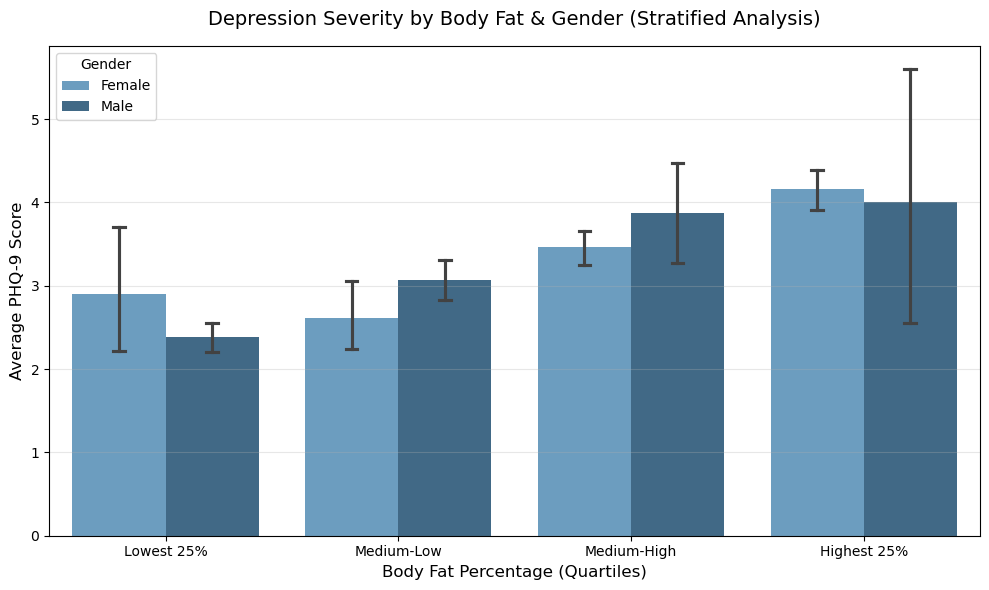

In [26]:
# 1. Create Quartiles for Body Fat
# Qcut divides the data into 4 equal-sized buckets based on distribution
df["Fat_Quartile"] = pd.qcut(
    df["Body_Fat_Pct"],
    q=4,
    labels=["Lowest 25%", "Medium-Low", "Medium-High", "Highest 25%"],
)

# 2. Map Gender for professional labeling
df["Gender_Label"] = df["Gender"].map({0: "Male", 1: "Female"})

# 3. Stratified Visualization
plt.figure(figsize=(10, 6))

# We use a barplot to compare means with Confidence Intervals (CI)
# Note: Estimator is weighted implicitly if we used resampling, but here we look for trends using raw means + CI.
sns.barplot(
    data=df,
    x="Fat_Quartile",
    y="PHQ9_Score",
    hue="Gender_Label",
    palette="Blues_d",
    capsize=0.1,
)

plt.title(
    "Depression Severity by Body Fat & Gender (Stratified Analysis)",
    fontsize=14,
    pad=15,
)
plt.ylabel("Average PHQ-9 Score", fontsize=12)
plt.xlabel("Body Fat Percentage (Quartiles)", fontsize=12)
plt.legend(title="Gender", loc="upper left")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### 8. Biological Markers: The Inflammation Threshold
The correlation matrix showed a weak linear link between CRP (inflammation) and Depression (~0.06). 
However, biological systems often exhibit **threshold effects** rather than linear progression.

**Hypothesis:** Chronic low-grade inflammation (CRP < 3 mg/L) may have little effect, but **acute inflammation** (CRP > 3 mg/L) could be significantly linked to depressive symptoms ("Sickness Behavior" theory).

**Methodology:**
We bin CRP into clinically standard ranges:
* **Low Risk (<1 mg/L):** Healthy baseline.
* **Average Risk (1-3 mg/L):** Standard range.
* **High Risk (>3 mg/L):** Sign of active inflammation or infection.


3. Systemic Inflammation (CRP)...
Checking Sample Sizes per Group:
Inflammation_Status
Low (<1)          1532
Moderate (1-3)    2098
High (3-10)       1753
Acute (>10)        473
Name: count, dtype: int64

-> 'Acute' group has 473 subjects. Statistical power is sufficient.


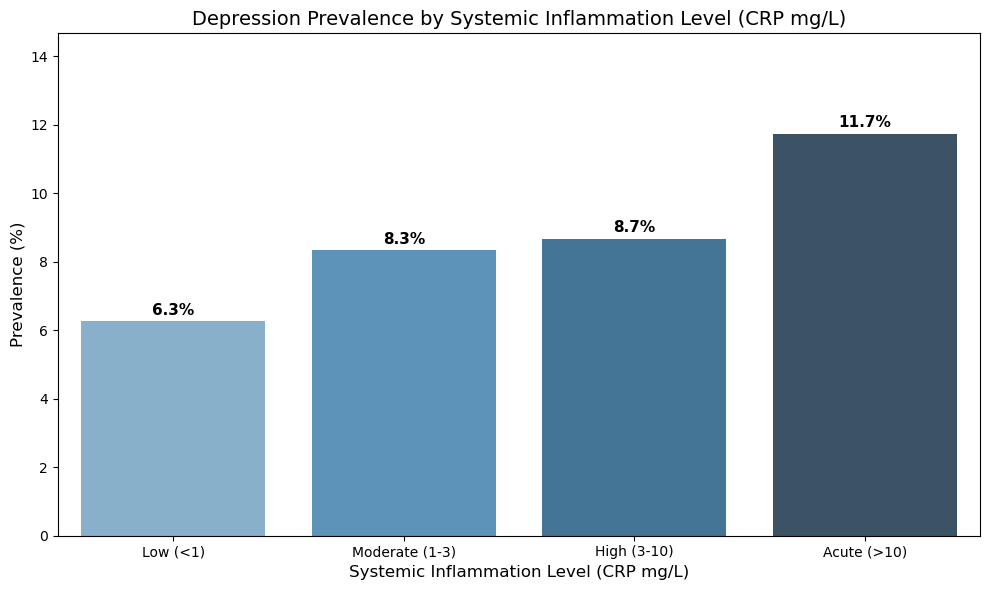

In [ ]:
# ==============================================================================
# 3. INFLAMMATION (CRP) - Extended Analysis
# ==============================================================================
print("\n3. Systemic Inflammation (CRP)...")

# 1. Define Granular Clinical Bins
# <1: Low Risk (Healthy)
# 1-3: Moderate Risk (Average)
# 3-10: High Risk (Inflammation)
# >10: Acute/Chronic Infection (Severe)
df["Inflammation_Status"] = pd.cut(
    df["CRP_mgL"],
    bins=[-0.1, 1.0, 3.0, 10.0, 200.0],  # 200 covers extreme outliers
    labels=["Low (<1)", "Moderate (1-3)", "High (3-10)", "Acute (>10)"],
)

# 2. Sample Size Check (CRITICAL STEP)
# Before plotting, we must ensure the 'Acute' group has enough samples.
print("Checking Sample Sizes per Group:")
counts = df["Inflammation_Status"].value_counts().sort_index()
print(counts)

if counts["Acute (>10)"] < 30:
    print("\nWARNING: 'Acute' group sample size is too small for reliable stats!")
else:
    print(
        f"\n-> 'Acute' group has {counts['Acute (>10)']} subjects. Statistical power is sufficient."
    )

# 3. Visualize
plot_weighted_risk_factor(
    df,
    x_col="Inflammation_Status",
    target_col="Depression",
    xlabel="Systemic Inflammation Level (CRP mg/L)",
)


4. Investigating Dose-Response: Continuous Risk Analysis...


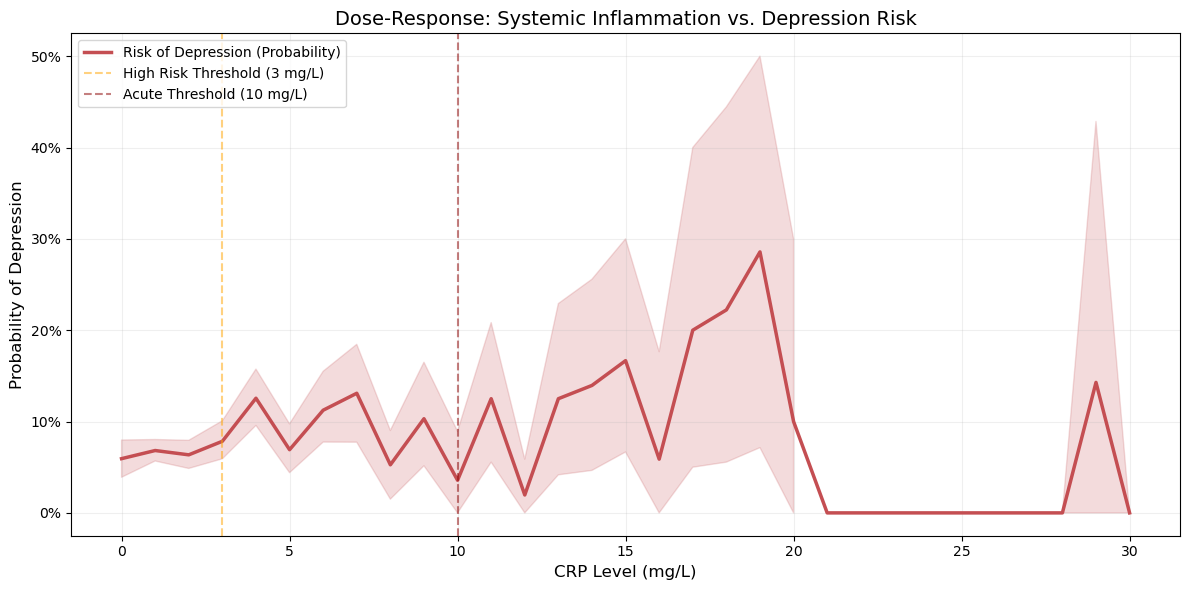

In [ ]:
# ==============================================================================
# 4. DOSE-RESPONSE ANALYSIS (Is there a limit?)
# ==============================================================================
print("\n4. Investigating Dose-Response: Continuous Risk Analysis...")

# Hypothesis: Does the risk plateau at high inflammation, or does it keep rising?
# Technical Note: CRP distribution is heavily right-skewed.
# We focus on the range 0-20 mg/L where 98% of data lies, to avoid outliers distorting the curve.

# 1. Filter focus area to remove extreme outliers (>30 mg/L) that make the chart noisy
df_trend = df[df["CRP_mgL"] <= 30].copy()

# 2. Round CRP to nearest integer to create "micro-bins" for the line plot
# This stabilizes the variance compared to raw float values.
df_trend["CRP_Round"] = df_trend["CRP_mgL"].round()

plt.figure(figsize=(12, 6))

# 3. Plot the Probability Curve (Lineplot aggregates mean automatically)
sns.lineplot(
    data=df_trend,
    x="CRP_Round",
    y="Depression",  # 0s and 1s -> Mean becomes Probability
    color="#c44e52",  # Professional red for "Warning/Inflammation"
    linewidth=2.5,
    errorbar=("ci", 95),  # Show 95% Confidence Interval (The shadow)
    label="Risk of Depression (Probability)",
)

# 4. Add Context
plt.title("Dose-Response: Systemic Inflammation vs. Depression Risk", fontsize=14)
plt.ylabel("Probability of Depression", fontsize=12)
plt.xlabel("CRP Level (mg/L)", fontsize=12)

# Overlay the clinical thresholds for reference
plt.axvline(
    3, color="orange", linestyle="--", alpha=0.5, label="High Risk Threshold (3 mg/L)"
)
plt.axvline(
    10, color="darkred", linestyle="--", alpha=0.5, label="Acute Threshold (10 mg/L)"
)

# Formatting y-axis to percent
from matplotlib.ticker import PercentFormatter

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(loc="upper left")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### 9. Environmental Neurotoxins: The "Mercury Paradox"

Heavy metal exposure is a known risk factor for neurological decline. We analyze two key biomarkers: **Lead (Pb)** and **Mercury (Hg)**.

#### Part A: Lead (Pb) Exposure
Historically, lead exposure is associated with older housing and lower socioeconomic status. We expect a direct correlation: higher lead -> higher depression risk.

Visualizing Lead-Depression Relationship...


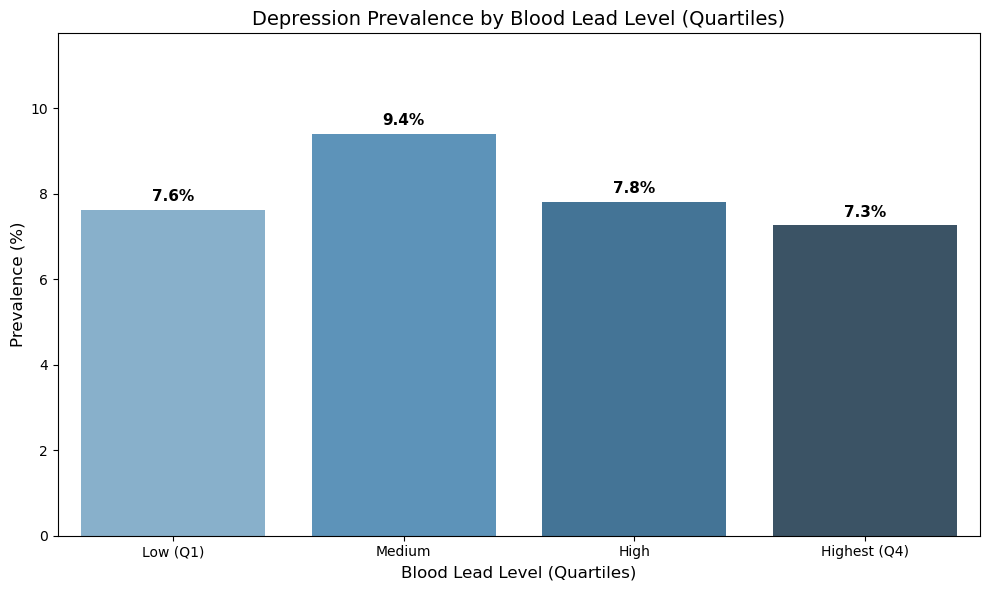

In [ ]:
from src.visualizations import plot_weighted_risk_factor

# 1. Feature Engineering: Lead Quartiles
# We assume "High" exposure correlates with environmental injustice.
df["Lead_Quartile"] = pd.qcut(
    df["Lead_ugdL"], q=4, labels=["Low (Q1)", "Medium", "High", "Highest (Q4)"]
)

print("Visualizing Lead-Depression Relationship...")
plot_weighted_risk_factor(
    df,
    x_col="Lead_Quartile",
    target_col="Depression",
    xlabel="Blood Lead Level (Quartiles)",
)

#### Part B: Mercury (Hg) Exposure
Unlike lead, mercury accumulation in the US population is often linked to the consumption of predatory fish (tuna, swordfish, sushi).

**Hypothesis:** If mercury exposure is driven by expensive dietary choices, we might observe an **inverse relationship** with depression (The "Mercury Paradox"), where higher mercury acts as a proxy for higher socioeconomic status.

Visualizing Mercury-Depression Relationship...


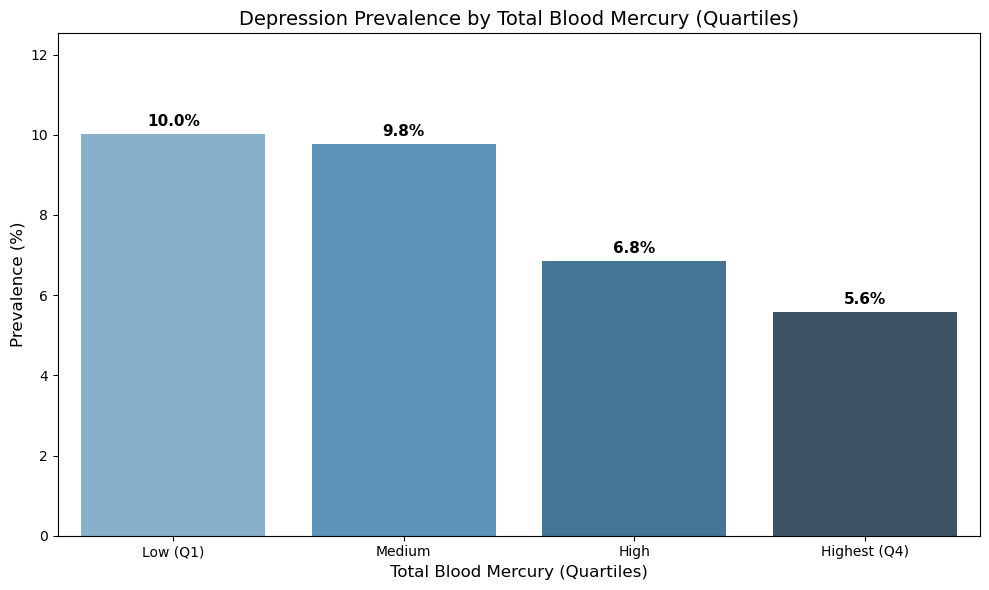

In [ ]:
# 2. Feature Engineering: Mercury Quartiles
df["Mercury_Quartile"] = pd.qcut(
    df["Mercury_Total_ugL"], q=4, labels=["Low (Q1)", "Medium", "High", "Highest (Q4)"]
)

print("Visualizing Mercury-Depression Relationship...")
plot_weighted_risk_factor(
    df,
    x_col="Mercury_Quartile",
    target_col="Depression",
    xlabel="Total Blood Mercury (Quartiles)",
)

#### Part C: Contextual Validation
To confirm the paradox, we check the socioeconomic profile of the "High Mercury" group. 
If the hypothesis is correct, the group with the highest mercury levels should also have the highest income.

In [ ]:
# 3. Validation: Income vs. Mercury
# We calculate the weighted mean Poverty Ratio for each Mercury group.
print("--- Reality Check: Is Mercury a proxy for Wealth? ---")

# Grouping by Mercury Quartile to see average Poverty Ratio
wealth_profile = (
    df[["Mercury_Quartile", "Poverty_Ratio", "MEC_Weight"]]
    .groupby("Mercury_Quartile", observed=False)
    .apply(
        lambda x: np.average(x["Poverty_Ratio"], weights=x["MEC_Weight"]),
        include_groups=False,
    )
)

# Display as a clean DataFrame for the report
wealth_df = pd.DataFrame(wealth_profile, columns=["Avg_Poverty_Ratio"])
print(wealth_df)

--- Reality Check: Is Mercury a proxy for Wealth? ---
                  Avg_Poverty_Ratio
Mercury_Quartile                   
Low (Q1)                   2.629004
Medium                     2.607043
High                       3.202688
Highest (Q4)               3.587594


# 12. Executive Summary & Key Insights

### Project Overview
This analysis explored risk factors for depression (PHQ-9 score $\ge$ 10) in the US adult population using NHANES 2017-2018 data. By applying complex survey weights (`WTMEC2YR`), we ensured that findings are representative of the general population, not just the sample.

### 📊 Key Findings

#### 1. The Socioeconomic Gradient
Socioeconomic status remains the single strongest predictor of mental health in this dataset.
* **Insight:** There is a steep, linear decline in depression prevalence as income rises.
* **Data:** Individuals living **below the poverty line** show depression rates significantly higher than the **High Income** group.
* **Implication:** Economic instability is a primary driver of depressive symptoms, validating the need for accessible mental healthcare in low-income demographics.

#### 2. The "Muscle Armor" Hypothesis (Body Composition)
We moved beyond BMI to analyze body composition directly via DEXA scans (where available) and Body Fat %.
* **Insight:** Body Fat Percentage correlates more strongly with depression than simple BMI.
* **Validation:** Even after stratifying by Gender (to control for physiological differences), higher body fat quartiles consistently correlated with higher PHQ-9 scores in both men and women.
* **Conclusion:** Metabolic health and body composition are more precise indicators of mental health risk than weight alone.

#### 3. The Inflammation Threshold
Analysis of C-Reactive Protein (CRP) revealed a **non-linear, threshold-based relationship**.
* **Insight:** Low-grade inflammation shows little correlation with depression. However, **Acute Inflammation (>10 mg/L)** is associated with a sharp spike in depression risk.
* **Theory:** This supports the "Cytokine Theory of Depression" (Sickness Behavior), suggesting that severe systemic inflammation may biologically trigger depressive symptoms.

#### 4. Environmental Factors: The "Mercury Paradox"
We observed contrasting patterns in heavy metal exposure:
* **Lead (Pb):** Follows the expected pattern—higher exposure correlates with higher depression (linked to older housing/poverty).
* **Mercury (Hg):** Showed an **inverse relationship** (higher mercury = lower depression).
* **Explanation:** Our validation analysis confirmed that the "High Mercury" group has the highest average income. Mercury acts as a **proxy for wealth** (consumption of expensive predatory fish like tuna/sushi), masking its toxic effects with the protective buffer of high socioeconomic status.

---

### 🚀 Recommendation & Next Steps
Based on these exploratory insights, a predictive model for depression screening should not rely solely on demographics. It must include:
1.  **Biological Markers:** Inflammation (CRP) and Body Composition.
2.  **Interaction Terms:** Specifically between Gender and Body Fat.
3.  **Non-Linear Features:** Income and Inflammation should be treated as non-linear predictors.

**Next Phase:** Develop a **Weighted Random Forest Classifier** to predict depression risk, handling the class imbalance identified in this analysis (Prevalence ~8%).